# Welcome to the pumapy tutorials

## Installation setup and imports

In [1]:
# GOOGLE COLAB: the first time you run this, it will take about 10 mins to setup
if 'google.colab' in str(get_ipython()):  #
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    # FEniCS-dolfin not working in Colab
    !if [[ $(conda list puma) != *"puma"* ]]; then conda install -c fsemerar puma; fi
    !pip install -q piglet pyvirtualdisplay
    !apt-get -qq install xvfb
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(600, 400))
    display.start()

else:  # NORMAL JUPYTER NOTEBOOK
    %matplotlib widget  # for interactive slicer (only static allowed on Colab)

UsageError: unrecognized arguments: # for interactive slicer (only static allowed on Colab)


In [7]:
import numpy as np
import pumapy as puma
import pyvista as pv
from TexGen.Core import *
import scipy.ndimage as nd
import os
import sys

## Tutorial 1: Workspace Manipulations
In this tutorial we demonstrate how to create a workspace and perform basic operations on it, including cropping, rotation, thresholding.

A workspace is the datastructure at the basis of both PuMA and pumapy and it is basically a container for the material sample that you want to analyze. A workspace is made of little cubes, or voxels (i.e. 3D pixels), holding a value. This simple element definition (formally called Cartesian grid) allows for very fast operations. Inside a workspace object, two different arrays are defined: one called "matrix" and the other called "orientation". Both of these are nothing but a 3D Numpy array for the matrix (X,Y,Z dimensions of the domain) and a 4D Numpy array for the orientation (dimensions of X,Y,Z,3 for vectors throughout the domain). 

Next we show the different ways we have implemented to define a workspace class:

In [8]:
# defines a workspace full of zeros of shape 10x11x12
ws1 = puma.Workspace.from_shape((10, 11, 12))
print("Shape of workspace 1: {}\n".format(ws1.matrix.shape))

# defines a workspace of shape 20x31x212, full of a custom value (in this case ones)
ws2 = puma.Workspace.from_shape_value((20, 31, 212), 1)
print("Shape of workspace 2: {}\n".format(ws2.matrix.shape))

# defines a workspace of shape 5x6x2, full of a custom value (in this case ones) for the matrix array
# and vectors for the orientation array
ws3 = puma.Workspace.from_shape_value_vector((5, 6, 2), 1, (0.4, 2, 5))
print("Matrix shape of workspace 3: {}".format(ws3.matrix.shape))
print("Orientation shape of workspace 3: {}".format(ws3.orientation.shape))
print("Display Workspace 3 matrix")
ws3.show_matrix()
print("\nDisplay Workspace 3 orientation")
ws3.show_orientation()

# we can also convert a Numpy array into a Workspace directly by running:
array = np.random.randint(5, size=(10, 10, 10))
ws4 = puma.Workspace.from_array(array)
print("\nMatrix shape of workspace 4: {}".format(ws4.get_shape()))

# finally, we can also create an empty workspace object and assign its matrix directly (not recommended):
ws5 = puma.Workspace()
ws5.matrix = np.random.randint(5, size=(10, 10, 3))
print("\nDisplay Workspace 5")
ws5.show_matrix()

print("\nDifferent ways to index the matrix array:")
# N.B. the following commands are equivalent
print(ws5[0, 0, 0])
print(ws5.matrix[0, 0, 0])

Shape of workspace 1: (10, 11, 12)

Shape of workspace 2: (20, 31, 212)

Matrix shape of workspace 3: (5, 6, 2)
Orientation shape of workspace 3: (5, 6, 2, 3)
Display Workspace 3 matrix

3D Workspace:
  o---> y
  |
x v
[(:,:,0)
[[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]

(:,:,1)
[[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]]

Display Workspace 3 orientation

3D Orientation:
  o---> y
  |
x v
[(:,:,0)
[[(0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0)]
[(0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0)]
[(0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0)]
[(0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0)]
[(0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0, 5.0)]

(:,:,1)
[[(0.4, 2.0, 5.0) (0.4, 2.0, 5.0) (0.4, 2.0

It is important to keep the first three dimensions (X,Y,Z) of the matrix and orientation class variables the same. This is automatically enforced by using the class methods, but it is not when assigning them directly as in the last example. 

We can import a tomography image directly into a workspace: 

In [9]:
ws_raw = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

Importing /Users/fsemerar/Documents/PuMA_playground/puma-dev/python/pumapy/data/200_fiberform.tif ... Done


The voxel length (in meters) of the workspace can either be set during import of a 3D tiff, or manually afterwards, as shown below: 

In [10]:
ws_raw.voxel_length = 1.3e-6

We can visualize its slices by running the command below. By scrolling on top of the plot, you can slice through the material along the z axis. You can also use the left/right arrows on the keyboard to skip +/-10 slices or the up/down arrows to skip +/-100 slices. In addition, on the bottom of the plot, the (x,y) coordinates are shown along with the corresponding grayscale value. 

Note that in Colab only static plots are allowed, so an index can be specified to indicate the slice to show.

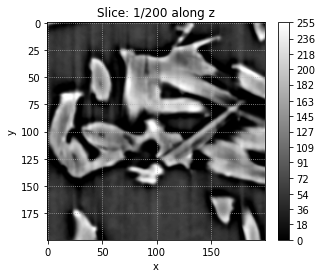

In [11]:
slices = puma.plot_slices(ws_raw, slice_direction='z', crange=None, cmap='gray', index=1)

Otherwise, we can also 3D render it as (see the visualization tutorial for more tips on this):

In [12]:
puma.render_volume(ws_raw, notebook=True)

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

Next, we show how to manipulate the domain, e.g. crop, rescale, resize and rotate it. 

An approach to crop a domain is the following:

In [13]:
ws_copy = ws_raw.copy()
ws_copy.matrix = ws_copy[10:40, 35:, -20:]
print("Shape of original workspace: {}".format(ws_raw.get_shape()))
print("Shape of cropped workspace: {}".format(ws_copy.get_shape()))

Shape of original workspace: (200, 200, 200)
Shape of cropped workspace: (30, 165, 20)


However, it is important to not fall in the trap of referencing the same Numpy array. Here is an example of how you SHOULD NOT perform cropping:

In [14]:
ws_bad = puma.Workspace()
ws_bad.matrix = ws_raw[10:40, 35:, -20:]  # WRONG: always make a copy first!
ws_bad[0, 0, 0] = np.random.randint(0, 255)  # otherwise, this line also changes ws_raw
print(ws_raw[10, 35, -20])
print(ws_bad[0, 0, 0])

94
94


As you can see from the output, both the original Workspace and the newly created one share the same Numpy array for the matrix class variable (the second one is only a section of it). This way, when one is changed, the other one will be changed as well. It is important to make a copy of a domain if the original workspace needs to be kept.

Next, we show how we can rescale a domain by a factor or resize it to a specified size. 

Rescaled workspace size: (100, 100, 100)


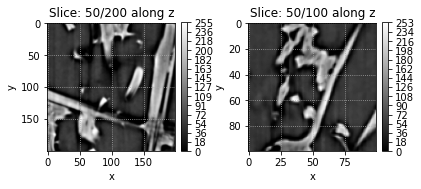

In [15]:
ws_copy = ws_raw.copy()
ws_copy.rescale(scale=0.5, segmented=False)

# Notice that now the axis have different limits
puma.compare_slices(ws_raw, ws_copy, index=50)

## Tutorial 2: import and export

In this tutorial we demonstrate how to input and output a computational domain in PuMA

### Explanation of data structures
First, we give a brief explanation of the PuMA data structures. For a more detailed description, refer to the workspace manipulation tutorial.

Microstructures in PuMA are stored in a data structure called a "workspace". The workspace class includes all of the data about the material microstructure, including a 3D matrix of grayscale values, which can be either raw data from tomographic images, or segmented values. 

Note that in Colab only static plots are allowed, so an index can be specified to indicate the slice to show.

Examples of unsegmented and segmented workspaces are demonstrated below: 

Importing /Users/fsemerar/Documents/PuMA_playground/puma-dev/python/pumapy/data/200_fiberform.tif ... Done


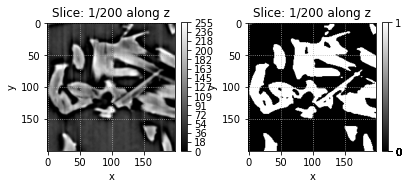

In [16]:
ws_unsegmented = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)
ws_segmented = ws_unsegmented.copy()
ws_segmented.binarize(90)

puma.compare_slices(ws_unsegmented, ws_segmented,'z', index=1)

The PuMA workspace class also contains other important information about the workspace. This includes the voxel length, which is the physical length, in meters, of each voxel of the image. Typical tomography data ranges from 1e-4 to 1e-7 meters in voxel length. If no value is provided to PuMA, the workspace class defaults to 1e-6 meters as a voxel length. This value can either be set during input-output or it can be set directly for the workspace class. 

An example is shown below, where the voxel length of a workspace class is manually changed

In [17]:
ws_unsegmented.voxel_length = 1.5e-6

The workspace class can also store the material orientation for each voxel in the domain. This data can either be imported, or can be computed using "compute_orientation_st" function, which applies the structure-tensor method to estimate the material orientation. 

### Workspace import and export
Now we will give examples of input and output for the workspace class. 

PuMA import and export uses three different file types: 3D tiff, vti, and binary (extension is .pumapy)

The 3D tiff images only include the 3D matrix data for the grayscale values. vti and binary, however, includes all data associated with the puma workspace class, including the matrix data, the orientation data (if used) and the voxel length. 

3D tiff images are often the exported data format for tomography imaging, so they are included in PuMA. If you have a tomographic image that uses a different file format, it is recommended to use an external image processing software (FIJI is recommended - https://imagej.net/software/fiji/) and convert the image to a 3D tiff before importing into pumapy.

First, let's set where to export the output file:

In [18]:
# Specify a path where to export file
export_path = 'out'  # CHANGE THIS PATH

if not os.path.exists(export_path):
    os.makedirs(export_path)

### Loading and exporting a .vti file

Now, we will import an example file from the example data inside the folder pumapy.data:

In [19]:
ws_vtk = puma.import_vti(puma.path_to_example_file("fibers_with_orientation.vti"))

print("Voxel Length: ", ws_vtk.voxel_length)
print("Domain shape: ", ws_vtk.get_shape())

Importing /Users/fsemerar/Documents/PuMA_playground/puma-dev/python/pumapy/data/fibers_with_orientation.vti ... Done
Voxel Length:  1.3e-06
Domain shape:  (50, 50, 50)


We can now visualize both the fibrous microstructure and the fiber orientation side by side (for more visualization tips, follow the visualization tutorial):

In [20]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Microstructure")
puma.render_contour(ws_vtk, (128, 255), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Fiber orientation")
puma.render_orientation(ws_vtk, notebook=True, add_to_plot=p, plot_directly=False)
p.show()

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

Finally, we will export it again to our specified directory:

In [21]:
puma.export_vti(os.path.join(export_path, "fibers_with_orientation.vti"), ws_vtk)

Exporting out/fibers_with_orientation.vti ... Done


True

And that's it for exportint to vti!  Let's repeat the same steps for .pumapy and 3D tiffs.

### Loading and exporting a .pumapy binary file

In [22]:
ws_binary = puma.import_bin(puma.path_to_example_file("fibers_with_orientation.pumapy"))

print("Voxel Length: ", ws_binary.voxel_length)
print("Domain shape: ", ws_binary.get_shape())

Importing /Users/fsemerar/Documents/PuMA_playground/puma-dev/python/pumapy/data/fibers_with_orientation.pumapy ... Done
Voxel Length:  1.3e-06
Domain shape:  (50, 50, 50)


In [23]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Microstructure")
puma.render_contour(ws_binary, (128, 255), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Fiber orientation")
puma.render_orientation(ws_binary, notebook=True, add_to_plot=p, plot_directly=False)
p.show()

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

In [24]:
puma.export_bin(os.path.join(export_path, "fibers_with_orientation.vti"), ws_binary)

Exporting out/fibers_with_orientation.vti.pumapy ... Done


True

### Loading and exporting a .tif stack

In [25]:
ws_tiff = puma.import_3Dtiff(puma.path_to_example_file("50_artfibers.tif"))

print("Voxel Length: ", ws_tiff.voxel_length)
print("Domain shape: ", ws_vtk.get_shape())

puma.render_contour(ws_tiff, (128,255), notebook=True)

puma.export_3Dtiff(os.path.join(export_path, "50_artfibers.tif"), ws_tiff)

Importing /Users/fsemerar/Documents/PuMA_playground/puma-dev/python/pumapy/data/50_artfibers.tif ... Done
Voxel Length:  1e-06
Domain shape:  (50, 50, 50)


ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

Exporting out/50_artfibers.tif ... Done


True

As you can see, with the 3D tiff import, the voxel length of the original workspace and the orientation is not preserved. The voxel length can be set by either adding it as an option to the 3D tiff import call, or by setting it directly: 

In [26]:
ws_tiff = puma.import_3Dtiff(puma.path_to_example_file("50_artfibers.tif"),1.3e-6)
print("Voxel Length - passed to input function: ", ws_tiff.voxel_length)

ws_tiff = puma.import_3Dtiff(puma.path_to_example_file("50_artfibers.tif"))
print("Voxel Length - no input set: ", ws_tiff.voxel_length)
ws_tiff.voxel_length = 1.3e-6
print("Voxel Length - manually changed: ", ws_tiff.voxel_length)

Importing /Users/fsemerar/Documents/PuMA_playground/puma-dev/python/pumapy/data/50_artfibers.tif ... Done
Voxel Length - passed to input function:  1.3e-06
Importing /Users/fsemerar/Documents/PuMA_playground/puma-dev/python/pumapy/data/50_artfibers.tif ... Done
Voxel Length - no input set:  1e-06
Voxel Length - manually changed:  1.3e-06


## Tutorial 3: 3D Visualization
In this tutorial we demonstrate the use of the 3D Visualization capabilities in pumapy. The 3D visualization is based on a coupling with Pyvista. Visualization can be performed on either raw tomography samples (each material phase is composed of a range of grayscale values) or segmented images (each material phase is a single grayscale value). Pumapy can currently produce volume, contour and orientation renderings. Examples of each visualization are shown below. 

Next we must either import or generate a material to visualize. Computational domains are stored in the workspace class. Below we show an example of both importing and computationally generating a material:

In [27]:
# Generating a workspace of randomly placed, intersecting spheres: with the inputs:
#  - size of domain in voxels: (200,200,200)
#  - diameter of each sphere in voxels: 20
#  - porosity of generated material: 0.7
ws_generated = puma.generate_random_spheres((200,200,200), 20, 0.7)

# The voxel length (in meters) of the workspace defaults to 1 micron (1e-6 m).
# To change the voxel length, modify the parameter directly: 
ws_generated.voxel_length = 1.3e-6

# Next we will import an example tomography file of size 200^3 and voxel length 1.3e-6
ws_imported = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

Approximately 818.5111359011762 spheres to be generated
Spheres Generated 1142  Porosity = 0.699793125 Importing /Users/fsemerar/Documents/PuMA_playground/puma-dev/python/pumapy/data/200_fiberform.tif ... Done


The workspaces above have not been segmented yet. In the case of generated workspace, the generated material has been stored for a grayscale [128,255] and the void phase is stored between [0,127]. The appropriate grayscale cutoff for the imported tomography sample is 90, such that [90,255] is material and [0,89] is the air/void. These values will be different for each tomography image. 

First, we will generate both volume and contour renderings of the two materials without segmentation. Since we are running the rendering from a jupyter notebook, we need to specify it.

In [28]:
# Generating contour (i.e. isosurface) rendering of the computationally generated material
# The grayscale range of the material to be rendered is specified as (128,255) and is inclusive
puma.render_contour(ws_generated, cutoff=(128, 255), notebook=True)

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

In [29]:
# Generating volume (i.e. voxel) rendering of the computationally generated material
puma.render_volume(ws_generated, cutoff=(128, 255), notebook=True)

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

In [30]:
# by choosing the "edges" style, we can visualize the triangulated surface
puma.render_contour(ws_imported, cutoff=(90, 255), notebook=True, style="edges")

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

In [31]:
puma.render_volume(ws_imported, cutoff=(90, 255), notebook=True)

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

Next, we will segment the workspaces, such that all void voxels contain an ID of 0 and all solid voxels contain an ID of 1. This could be expanded for multi-phase domains. 

In [32]:
# Setting all grayscale values between 0 and 127, inclusive, to 0
ws_generated.set_material_id((0, 127), 0)
# Setting all grayscale values between 128 and 255, inclusive, to 1
ws_generated.set_material_id((128, 255),1)
# The above could also be achieved as: ws_generated.binarize_range((128, 255))

# Now on the tomography, we can binarize it using a single threshold as:
ws_imported.binarize(89)  # everything above 89 will be set 1, below to 0

Now we will generate contour and volume renderings of the segmented files. Note that the grayscale values have changed. In the case of the contour render, the new grayscale values can be specified by either setting the appropriate range - (1,1) in this case, or by specifying the material ID value itself - 1 in this case. For the volume render, the range of grayscales to be considered must be included, in this case simply (1,1)

In [33]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Surface")
puma.render_contour(ws_generated, cutoff=(1, 1), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Voxels")
puma.render_volume(ws_generated, cutoff=(1, 1), notebook=True, add_to_plot=p, plot_directly=False)
p.show()

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

In [34]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Surface")
puma.render_contour(ws_imported, cutoff=(1, 1), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Voxels")
puma.render_volume(ws_imported, cutoff=(1, 1), notebook=True, add_to_plot=p, plot_directly=False)
p.show()

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

Note that the contour renders for the segmented images are significantly less smooth than for the non-segmented images. This is because for segmented images, the triangulation algorithms have significantly less degrees of freedom when assigning triangle angles, resulting in a rougher surface than for non-segmented images. 

## Tutorial 4: Multi-phase material
Although all of the required information for performing simulations on a multi-phase material are already present in the other tutorials, this tutorial is designed to help the user understand how to perform basic visualizations and simulations on a material with more than one solid phase. 

For the example here, we are using an artifically generated material with three phases: Random fibers, a bindnig material between the fibers, and randomly populated spheres 

### Material Generation

First, we will generate a material with 2 different types of fibers, and one type of sphere. 

The two fibers will be stored with material ID 1, and 2, and the sphere will be stored with material ID 3. 

Specify the output directory for the files to be generated:

In [35]:
export_path = "out"

if not os.path.exists(export_path):
    os.makedirs(export_path)

In [36]:
size = (200,200,200)  # size of the domain, in voxels. 
radius = 8  # radius of the fibers to be generated, in voxels
nFibers = None # Can specify either the number of fibers or the porosity
porosity = 0.9  # porosity of the overall structure
phi = 90 # A value between 0 and 90 that controls the amount that the fibers lie *out of* the XY plane,
         # with 0 meaning all fibers lie in the XY plane, and 90 meaning that cylinders are randomly oriented out of the
         # plane by as much as +/- 90 degrees.
theta = 90 # A value between 0 and 90 that controls the amount of rotation *in the* XY plane,
           # with 0 meaning all fibers point in the X-direction, and 90 meaning they are randomly rotated about the
           # Z axis by as much as +/- 90 degrees.
length = 200 # Length of the fibers to be generated

ws_fibers1 = puma.generate_random_fibers(size,radius,nFibers,porosity,phi,theta,length)

radius = 5  # creating smaller fibers for material #2
length = 50

ws_fibers2 = puma.generate_random_fibers(size,radius,nFibers,porosity,phi,theta,length)
ws_fibers2.set_material_id((1,1),2)

# combining fibers #1 and fibers #2 into a single domain, and setting the overlap to default to fibers #1
ws_fibers1.matrix = ws_fibers1.matrix + ws_fibers2.matrix
ws_fibers1.set_material_id((3,3),1) # setting the overlap, which would be 3, equal to 1


# Generating the spheres
diameter = 20  # diameter of the spheres to be generated, in voxels
porosity = 0.8  # porosity of the overall structure
allow_intersections = True # flag on whether to allow intersections between spheres. 
# Note: If allow_intersections is set to false, it will be significantly slower to generate,
#.      and will usually require a fairly high porosity value to be generated

ws_spheres = puma.generate_random_spheres(size, diameter, porosity, allow_intersections)
ws_spheres.set_material_id((0,127),0)
ws_spheres.set_material_id((128,255),3)

# combining all three materials, with overlap defaulting to the sphere material
ws_fibers1.matrix = ws_fibers1.matrix + ws_spheres.matrix
ws_fibers1.set_material_id((4,5),3) # setting the overlap, which would be either 4 or 5, equal to 3

puma.export_3Dtiff(os.path.join(export_path, "multiphase.tif"), ws_fibers1)

ws_multiphase = ws_fibers1

Generating fibers ... 100.0% 
Generated random fibers domain with porosity: 0.902758375
Generating fibers ... 100.0% 
Generated random fibers domain with porosity: 0.898672125
Approximately 477.4648292756858 spheres to be generated
Spheres Generated 691  Porosity = 0.79983625 Exporting out/multiphase.tif ... Done


### Material Visualization

Now we will plot a slice of the material and visualize each of the three phases:

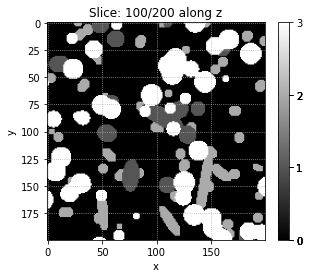

In [37]:
slices = puma.plot_slices(ws_multiphase, index=100)

In [38]:
puma.render_contour(ws_multiphase, cutoff=(1, 1), notebook=True)

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

In [39]:
puma.render_contour(ws_multiphase, cutoff=(2, 2), notebook=True)

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

In [40]:
puma.render_contour(ws_multiphase, cutoff=(3, 3), notebook=True)

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

We can also visualize the three-phase material using either the volume_render for showing a voxel representation or the puma.render_contour_multiphase function for a smooth triangulated surface representation: 

In [41]:
puma.render_volume(ws_multiphase, cutoff=(1, 3), solid_color=None, notebook=True, cmap='gray')

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

In [42]:
cutoffs = [(1, 1)]  # material phase 1
cutoffs.append((2, 2)) # material phase 2
cutoffs.append((3, 3)) # material phase 3

# if solid_colors is not provided, the color of the phases is randomized
puma.render_contour_multiphase(ws_multiphase, cutoffs, notebook=True, 
                               solid_colors=((0., 0., 0.), (0.5, 0.5, 0.5), (1., 1., 1.)))

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

### Volume Fractions

To calculate the volume fractions of each material phase, we will use the puma.compute_volume_fraction function and specify the grayscale range of each material: 

In [43]:
vf_void = puma.compute_volume_fraction(ws_multiphase, (0,0))
vf_phase1 = puma.compute_volume_fraction(ws_multiphase, (1,1))
vf_phase2 = puma.compute_volume_fraction(ws_multiphase, (2,2))
vf_phase3 = puma.compute_volume_fraction(ws_multiphase, (3,3))
vf_solid = puma.compute_volume_fraction(ws_multiphase, (1,3))

print("Volume Fraction of Void (Porosity):", vf_void)
print("Volume Fraction of Phase 1:", vf_phase1)
print("Volume Fraction of Phase 2:", vf_phase2)
print("Volume Fraction of Phase 3:", vf_phase3)
print("Volume Fraction of All Three Phases:", vf_solid)

Volume Fraction of Void (Porosity): 0.65046325
Volume Fraction of Phase 1: 0.075596625
Volume Fraction of Phase 2: 0.073776375
Volume Fraction of Phase 3: 0.20016375
Volume Fraction of All Three Phases: 0.34953675


### Surface Area

To calculate the total surface area of the entire material phase, we can use the puma.compute_surface_area function with the material cutoff of (1,3) which includes all 3 material phases

In [44]:
area, specific_area = puma.compute_surface_area(ws_multiphase, (1,3))
print("Areas:", area, specific_area)

Areas: 7.49868125e-07 95153.69643855756


Computing the surface area of each individual phase is a little bit more tricky. To demonstrate, refer to the simple 2D schematic below of a 2-phase material.

![image info](https://github.com/nasa/puma/raw/main/python/tutorials/pictures/multiphase.png)

The materials are each labeled, 1, and 2, and the edge lengths are labeled a, b, and c. The total surface area of both materials is defined as A<sub>total</sub> = a + b. Assuming that your materials are stored with grayscale values 1 and 2, this total surface area is calculated as before in the 3-material example: puma.compute_surface_area(ws_multiphase, (1,2))

However, if you want to know the surface area of an individual phase, there are two options. You can compute the total surface area of the individual phase, including the surface area contact with other material phases, or you can compute only the exposed surface area to the void phase. The latter would be the relevant quantity when computing, for example, the effective reactive surface area for chemical reactions. In the first case, the surface area can be calculated as

Area = A<sub>1</sub> = a + c = puma.compute_surface_area(ws_multiphase, (1,2))

Area = 0.5 ( A<sub>1</sub> + A<sub>1-2</sub> - A<sub>2</sub> ) = 0.5 * (a + b + a + c - b - c) = a

which, written in puma commands, becomes --> Area = puma.compute_surface_area(ws_multiphase, (1,1)) + puma.compute_surface_area(ws_multiphase, (1,2)) - puma.compute_surface_area(ws_multiphase, (2,2))

For our 3-phase material, it is quite similar:

To compute the surface area of material 1 exposed to the void, 

Area = 0.5 ( A<sub>1</sub> + A<sub>1-2-3</sub> - A<sub>2-3</sub> ) = 0.5 * (a + d + f + a + b + c - d - b - c - f) = a

    

Below, we compute the exposed to void surface area of each of the three phases: Note that computing the surface area of the union between 1 and 3 requires extra steps, since using the surface area calculation on the domain with cutoffs (1,3) would include phase 2. Instead we copy the domain, set material 3 to an ID of 1, and then compute the surface area of material 1, which now includes material 3

In [45]:
# Raw and specific surface area calculations
Area_1, SSA_1 = puma.compute_surface_area(ws_multiphase, (1,1))  # a + d + f
Area_2, SSA_2 = puma.compute_surface_area(ws_multiphase, (2,2))  # d + b + e
Area_3, SSA_3 = puma.compute_surface_area(ws_multiphase, (3,3))  # f + e + c

Area_12, SSA_12 = puma.compute_surface_area(ws_multiphase, (1,2))  # a + b + e + f
Area_23, SSA_23 = puma.compute_surface_area(ws_multiphase, (2,3))  # d + b + c + f
Area_123, SSA_123 = puma.compute_surface_area(ws_multiphase, (1,3)) # a 

ws_copy = ws_multiphase.copy()
ws_copy.set_material_id((3,3),1)  # setting all of phase 3 to be equal to ID 1
Area_13, SSA_13 = puma.compute_surface_area(ws_copy, (1,1))  # a + d + e + c

# Now to compute the exposed surface areas for each phase: 
Exposed_Area_1 = 0.5 * (Area_1 + Area_123 - Area_23)
Exposed_SSA_1 = 0.5 * (SSA_1 + SSA_123 - SSA_23)

Exposed_Area_2 = 0.5 * (Area_2 + Area_123 - Area_13)
Exposed_SSA_2 = 0.5 * (SSA_2 + SSA_123 - SSA_13)

Exposed_Area_3 = 0.5 * (Area_3 + Area_123 - Area_12)
Exposed_SSA_3 = 0.5 * (SSA_3 + SSA_123 - SSA_12)

print("Exposed Areas for Phase 1:", Exposed_Area_1, Exposed_SSA_1)
print("Exposed Areas for Phase 2:", Exposed_Area_2, Exposed_SSA_2)
print("Exposed Areas for Phase 3:", Exposed_Area_3, Exposed_SSA_3)

Exposed Areas for Phase 1: 1.4913446093749998e-07 18924.254480845935
Exposed Areas for Phase 2: 2.395540625e-07 30397.951031387347
Exposed Areas for Phase 3: 3.5892231249999996e-07 45545.05469698434


As a check, we will test to make sure that the total exposed areas of each phase sum up to the total surface area of all of the material phases: 

In [46]:
print("Sum of Exposed Phase Area:", Exposed_SSA_1 + Exposed_SSA_2 + Exposed_SSA_3)
print("Total Area:", SSA_123)
print("Percent Error: ", np.abs((Exposed_SSA_1 + Exposed_SSA_2 + Exposed_SSA_3 - SSA_123)) / SSA_123 * 100.)

Sum of Exposed Phase Area: 94867.26020921762
Total Area: 95153.69643855756
Percent Error:  0.30102480519491825


We can see that the two values are very close but not exactly the same. This slight difference is simply numerical error from the triangulations and accounts for a 0.28% error in this case, which should not be too significant. 

### Tortuosity Factors

Computing the tortuosity factors for a multi-phase material is not different than for a single phase material, since it is only the void phase that is specified for the calculation. 

To speed up the simulation, we will take a 100<sup>3</sup> subsection of the domain in order to perform the tortuosity simulation. Please note that this domain size is almost certainly not a representative volume, and a far larger size should be used when performing production simulations

In [47]:
# The tortuosity calculation needs to be run for each of the three simulation directions. 
# For each simulation, a concentration gradient is forced in the simulation direction, and converged to steady state

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cutoff - the grayscale values for the void phase. [0,0] for this sample
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

ws_cropped = ws_multiphase.copy()  # creating a copy of the workspace to crop
ws_cropped.matrix = ws_cropped.matrix[50:150,50:150,50:150]  # cropping the sample to 100^3

n_eff_x, Deff_x, poro, C_x = puma.compute_continuum_tortuosity(ws_cropped, (0,0), 'x', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_y, Deff_y, poro, C_y = puma.compute_continuum_tortuosity(ws_cropped, (0,0), 'y', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_z, Deff_z, poro, C_z = puma.compute_continuum_tortuosity(ws_cropped, (0,0), 'z', side_bc='s', tolerance=1e-3, solver_type='cg')

print("Effective tortuosity factors:")
print(n_eff_x)
print(n_eff_y)
print(n_eff_z)

print("Porosity of the material:", poro)

Creating conductivity matrix ... Done
Initializing temperature field ... Done
Setting up b matrix ... Done
Assembling A matrix ... 100.0% Done
Setting up preconditioner ...Done
Time to sep up A matrix:  0.633131671000001
Solving Ax=b system ... Conjugate Gradient:
Iteration 372  Residual = 0.0009882639361976388  ... Done
Time to solve:  12.240191847000006
Computing flux from converged temperature field ... Done
Computing effective conductivity... Time to compute fluxes:  0.06855932099998086
Creating conductivity matrix ... Done
Initializing temperature field ... Done
Setting up b matrix ... Done
Assembling A matrix ... 100.0% Done
Setting up preconditioner ...Done
Time to sep up A matrix:  0.5577469909999877
Solving Ax=b system ... Conjugate Gradient:
Iteration 356  Residual = 0.0009989003456671124  ... Done
Time to solve:  11.147666630999993
Computing flux from converged temperature field ... Done
Computing effective conductivity... Time to compute fluxes:  0.056732068999991725
Creati

In [48]:
# Visualizing the Concentration field for the simulation along the x-axis:  
puma.render_volume(C_x, solid_color=None, notebook=True, cmap='jet')

ViewInteractiveWidget(height=1200, layout=Layout(height='auto', width='100%'), width=1920)

### Effective Thermal Conductivity

Computing the effective thermal conductivity is also very similar to in a single-phase case. The only difference is that rather than two materials being specified (void and solid) in the conductivity map, an entry must be made for each material phase, and the corresponding constituent thermal conductivity must be set. 

In [ ]:
# Generating a conductivity map. This stores the conductivity values for each phase of the material
cond_map = puma.IsotropicConductivityMap()
# First, we set the conductivity of the void phase to be 0.0257 (air at STP)
cond_map.add_material((0, 0), 0.0257)
# Next we set the conductivity of each of the three material phases
cond_map.add_material((1, 1), 10)
cond_map.add_material((2, 2), 20)
cond_map.add_material((3, 3), 100)

# The thermal conductivity calculation needs to be run for each of the three simulation directions. 
# For each simulation, a temperature gradient is forced in the simulation direction, and converged to steady state

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cond_map - the conductivity values for each material phase
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

k_eff_x, T_x, q_x = puma.compute_thermal_conductivity(ws_cropped,cond_map, 'x', 's', tolerance=1e-4, solver_type='bicgstab')
k_eff_y, T_y, q_y = puma.compute_thermal_conductivity(ws_cropped,cond_map, 'y', 's', tolerance=1e-4, solver_type='bicgstab')
k_eff_z, T_z, q_z = puma.compute_thermal_conductivity(ws_cropped,cond_map, 'z', 's', tolerance=1e-4, solver_type='bicgstab')

print("Effective thermal conductivity tensor:")
print(k_eff_x)
print(k_eff_y)
print(k_eff_z)

Creating conductivity matrix ... Done
Initializing temperature field ... Done
Setting up b matrix ... Done
Assembling A matrix ... 100.0% Done
Setting up preconditioner ...Done
Time to sep up A matrix:  0.6347931610000046
Solving Ax=b system ... Bicgstab:
Iteration 1019  Residual = 0.06198007050870066  

In [ ]:
# Visualizing the temperature field for the simulation along the y-axis: 
puma.render_volume(T_y, solid_color=None, notebook=True, cmap='jet')

## Tutorial 5: Generating Random Fiber Structures
In this tutorial we demonstrate how to generate a microstructure of random intersecting fibers

We generate the fiber structure and store it into the PuMA workspace class. 

In [ ]:
size = (200, 200, 200)  # size of the domain, in voxels. 
radius = 8  # radius of the fibers to be generated, in voxels
nFibers = None # Can specify either the number of fibers or the porosity
porosity = 0.8  # porosity of the overall structure
phi = 90 # A value between 0 and 90 that controls the amount that the fibers lie *out of* the XY plane,
         # with 0 meaning all fibers lie in the XY plane, and 90 meaning that cylinders are randomly oriented out of the
         # plane by as much as +/- 90 degrees.
theta = 90 # A value between 0 and 90 that controls the amount of rotation *in the* XY plane,
           # with 0 meaning all fibers point in the X-direction, and 90 meaning they are randomly rotated about the
           # Z axis by as much as +/- 90 degrees.
length = 200 # Length of the fibers to be generated

ws_fibers = puma.generate_random_fibers(size, radius, nFibers, porosity, phi, theta, length)

The material is now stored in the puma workspace, ws_fibers. By default, the grayscale value of 0 is assigned to the void space and a grayscale value of 1 is assigned to the material. 

Next we will visualize the domain: 

In [ ]:
# visualizing the solid domain
puma.render_contour(ws_fibers, cutoff=(1, 1), notebook=True)

If you would like to visualize the individual sices, this can be done using the plot_slices function

In [ ]:
puma.plot_slices(ws_fibers)

## Tutorial 6: Generating Random Sphere Structures
In this tutorial we demonstrate how to generate a microstructure of random intersecting spheres

We generate the sphere structure and store it into the PuMA workspace class. 

In [ ]:
size = (400, 400, 400)  # size of the domain, in voxels. 
diameter = 20  # diameter of the spheres to be generated, in voxels
porosity = 0.8  # porosity of the overall structure
allow_intersections = True # flag on whether to allow intersections between spheres. 
# Note: If allow_intersections is set to false, it will be significantly slower to generate,
#.      and will usually require a fairly high porosity value to be generated

ws_spheres = puma.generate_random_spheres(size, diameter, porosity, allow_intersections)

The material is now stored in the puma workspace, ws_spheres. By default, the grayscale range of [0,127] corresponds to the void space, and [128,255] contains the material. 

Next we will visualize the domain: 

In [ ]:
# visualizing the solid domain, contained in [128,255] grayscale range. 
puma.render_contour(ws_spheres, cutoff=(128, 255), notebook=True)

If you would like to segment the domain, that can be done using the binarize function, or the set_material_id function. 

In [ ]:
ws_spheres_binary = ws_spheres.copy()

# binarize(128) sets all grayscale values below 128 to 0, 
# and all grayscale values above and equal to 128 to 1
ws_spheres_binary.binarize(128)

puma.compare_slices(ws_spheres, ws_spheres_binary)

## Tutorial 7: Generating Triply Periodic Minimal Surfaces
In this tutorial we demonstrate how to generate a TPMS microstructure 

We generate the TPMS structure. There are three different equations that can be used in the TPMS generator: 

Equation 0: grayscale value = q + sin(wx)*sin(wy)*sin(wz) + sin(wx)*cos(wy)*cos(wz) + cos(wx)*sin(wy)*cos(wz) + cos(wx)*cos(wy)*sin(wz)

Equation 1: grayscale value = q + cos(wx)*sin(wy) + cos(wy)*sin(wz) + cos(wi)*cos(wz)

Equation 2: grayscale value = q + cos(wx) + cos(wy) + cos(wz)

The values of w and q can either be provided as single values, or as a tuple. If a tuple is used, then the first and second values will be the minimum and maximum values for q and w, and the value will vary linearly between the two along the z-axis.

The value of w controls the pore diameter and the value of q controls the porosity

In [ ]:
size = (400, 400, 400)  # size of the domain, in voxels. 
w = 0.08  # value of w in the equations above
q = 0.2  # value of q in the equations above

ws_eq0 = puma.generate_tpms(size, w, q, equation=0)
ws_eq1 = puma.generate_tpms(size, w, q, equation=1)
ws_eq2 = puma.generate_tpms(size, w, q, equation=2)

The material is now stored in the puma workspace. By default, the grayscale range of [0,127] corresponds to the void space, and [128,255] contains the material. 

Next we will visualize slices of the domains: 

In [ ]:
puma.plot_slices(ws_eq0)

In [ ]:
puma.plot_slices(ws_eq1)

In [ ]:
puma.plot_slices(ws_eq2)

Next, we will visualize the 3d Domains. To render the domain, the grayscale range corresponding to the material must be specified. In this case, the range of [128,255] corresponds to the material. 

In [ ]:
puma.render_contour(ws_eq0, cutoff=(128, 255), notebook=True)

In [ ]:
puma.render_contour(ws_eq1, cutoff=(128, 255), notebook=True)

In [ ]:
puma.render_contour(ws_eq2, cutoff=(128, 255), notebook=True)

If you would like to segment the domain, that can be done using the binarize function, or the set_material_id function. 

In [ ]:
# binarize(128) sets all grayscale values below 128 to 0, and all grayscale values above and equal to 128 to 1
ws_eq0.binarize(128)
ws_eq1.binarize(128)
ws_eq2.binarize(128)

In [ ]:
puma.plot_slices(ws_eq0)

In [ ]:
puma.plot_slices(ws_eq1)

In [ ]:
puma.plot_slices(ws_eq2)

## Tutorial 8: Weaves
In this tutorial we demonstrate the creation of weaves using TexGen and how to import them into PuMApy. TexGen python scrips can be simply obtained by either following TexGen tutorials https://github.com/louisepb/TexGenScriptingGuide or by recording the actions in the TexGen GUI (of which there are already
bundled executables for Windows at https://sourceforge.net/projects/texgen/files/). 

Let's start by creating a simple LayerToLayer weave using a TexGen python script. 

In [ ]:
NumBinderLayers = 2 
NumXYarns = 3 
NumYYarns = 4 
XSpacing = 1.0
YSpacing = 1.0 
XHeight = 0.2 
YHeight = 0.2 
weave = CTextileLayerToLayer(NumXYarns, NumYYarns, XSpacing, YSpacing, XHeight, YHeight, NumBinderLayers)

#set number of binder / warp yarns
NumBinderYarns = 2
NumWarpYarns = NumXYarns - NumBinderYarns
weave.SetWarpRatio(NumWarpYarns)
weave.SetBinderRatio(NumBinderYarns)

#setup layers: 3 warp, 4 weft
weave.SetupLayers( 3, 4, NumBinderLayers)

#set yarn dimensions: widths / heights
weave.SetYYarnWidths(0.8)
weave.SetYYarnWidths(0.8)
weave.SetBinderYarnWidths(0.4)
weave.SetBinderYarnHeights(0.1)

#define offsets for the two binder yarns
P = [[0, 1, 3, 0],[3, 0, 0, 3]]

#assign the z-positions to the binder yarns
for y in range(NumWarpYarns,NumXYarns): #loop through number of binder yarns
	offset = 0 
	for x in range(NumYYarns): #loop through the node positions	
		weave.SetBinderPosition(x, y, P[y-NumWarpYarns][offset])
		offset += 1

Next we create the domain, i.e. the lengths of the box containing the weave. In this case we will let TexGen figure it out automatically using the AssignDefaultDomain function:

In [ ]:
weave.AssignDefaultDomain()
domain = weave.GetDefaultDomain()

Now we need to specify a folder to export our TexGen weave

In [ ]:
export_path = "out"  # CHANGE THIS PATH

if not os.path.exists(export_path):
    os.makedirs(export_path)

Then, we pass the weave and the domain to the PuMApy exporter, which creates the voxel grid and exports it to the specified directory (expensive step ~1.5-2 mins):

In [ ]:
puma.export_weave_vtu(os.path.join(export_path, "weavetest"), weave, domain, 200)

This can be then read back into a pumapy.Workspace:

In [ ]:
ws = puma.import_weave_vtu(os.path.join(export_path, "weavetest_200"))

And we can volume render it (remember to close the popup window with 'q', not directly):

In [ ]:
puma.render_volume(ws, cutoff=(1, ws.matrix.max()), solid_color=None, notebook=True, cmap='jet')

## Tutorial 9: STL generation and output

In this tutorial, we will generate a water-tight STL file, visualize the STL, and output to file

The pumapy STL generation uses the Lewiner marching cubes implementation from scikit-image. The C++ version of PuMA also includes an implementation of the original and Lewiner marching cubes. 

The Lewiner marching cubes method is used to generate STLs because the surface is guaranteed to be topologically correct (i.e watertight). The original marching cubes is suitable for visualization purposes, but had ambiguitites that resulted in small holes in the surface mesh. 

We must either import or generate a material. Here we will import a material. If you prefer to generate a material instead, refer to the material generation tutorials. 

In [ ]:
# Next we will import an example tomography file of size 200^3 and voxel length 1.3e-6
ws_imported = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

The workspace above has not been segmented yet. In the case of generated workspaces, the generated material is typically stored for a grayscale [128,255] and the void phase is stored between [0,127]. 

In this case, the appropriate grayscale cutoff for the imported tomography sample is 90, such that [90,255] is material and [0,89] is the void. These values will be different for each tomography image. 

It is usually better to generate an STL based on a non-segmented material. This is because the segmentation process removes most of the information defining the surface from the tomography data. As an illustration, the code below will visualze the segmented and non-segmented versions of the imported tomography file. 

In [ ]:
ws_segmented = ws_imported.copy()
ws_segmented.binarize(90)

In [ ]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Raw grayscales")
puma.render_volume(ws_imported, notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Segmented")
puma.render_volume(ws_segmented, notebook=True, add_to_plot=p, plot_directly=False)
p.update_scalar_bar_range(1)
p.show()

In [ ]:
p = pv.Plotter(shape=(1, 2), notebook=True)
p.subplot(0, 0)
p.add_text("Raw grayscales")
puma.render_contour(ws_imported, cutoff=(90, 255), notebook=True, add_to_plot=p, plot_directly=False)
p.subplot(0, 1)
p.add_text("Segmented")
puma.render_contour(ws_segmented, cutoff=(1, 1), notebook=True, add_to_plot=p, plot_directly=False)
p.show()

As you can see, the non-segmented image provides a far superior surface representation. Because of this, we will use the non-segmented material for the STL generation. 

In order to output an STL, one must simply call the puma.export_stl function, as shown below:

Let's now export the STL. We need to first specify a path:

In [ ]:
export_path = "out"  # CHANGE THIS PATH

if not os.path.exists(export_path):
    os.makedirs(export_path)

In [ ]:
filename = "FiberForm-nonsegmented.stl"
cutoff = (90,255)  # tuple containing the grayscale range of the material to be exported
flag_closed_edges = True  # flag for whether to cap the regions of the material that intersect with the domain boundary

puma.export_stl(os.path.join(export_path, filename), ws_imported, cutoff, flag_closed_edges)

If you have no choice but to use a segmented image to export an stl, the flag_gauissian option can be set to True, which will apply a gauissian blur to the image prior to running the marching cubes algorithm. This will make the surface appear more smooth, but will also blur out any sharp features that may be present in the actual microstructure. 

In [ ]:
filename = "FiberForm-segmented.stl"
cutoff = (1,1)  # tuple containing the grayscale range of the material to be exported
flag_closed_edges = True  # flag for whether to cap the regions of the material that intersect with the domain boundary

puma.export_stl(os.path.join(export_path, filename), ws_segmented, cutoff, flag_closed_edges, flag_gaussian=False)

filename = "FiberForm-segmented-gaussian.stl"
puma.export_stl(os.path.join(export_path, filename), ws_segmented, cutoff, flag_closed_edges, flag_gaussian=True)

The STLs can be imported into other software for simulation or visualization purposes

## Tutorial 10: Calculating Surface Area
In this tutorial we demonstrate how to calculate the surface area of a microstructure

We import or generate the microstructure

In [ ]:
ws_fiberform = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

The calculation of the surface area requires the value for the voxel length to be set. The voxel length can be set during import, as shown above. The voxel length can also be set for the workspace directly, as shown below: 

In [ ]:
ws_fiberform.voxel_length = 1.3e-6  # setting the voxel length in meters

For an accurate calculation of the surface area, it is recommended to use an unsegmented domain. In a segmented domain, each phase is entire defined by a single grayscale value (i.e 0 for void and 1 for solid). In an unsegmented domain, the material phases are specified by a range of grayscale value. In the case of the imported tomography, the void range is [0,89] and the solid range is [90,255], as shown by the plotted slice below: 

In [ ]:
puma.plot_slices(ws_fiberform)

An unsegmented domain is recommended because the surface are relies on the marching cubes triangulation of the isosurface, which is much more accurate for an unsegmented domain than a segmented domain. 

To calculate the surface area, we use the puma.compute_surface_area function: The function returns both the raw area and the specific surface area. The specific surface area is the more often used quantity, and defines the surface area divided by the volume of the domain, with units of 1/m. 

In [ ]:
cutoff = (90, 255)  # specifying the grayscale range of the phase of interest

area_us, specific_area_us = puma.compute_surface_area(ws_fiberform, cutoff)
print("Unsegmented:",area_us,specific_area_us)

If a segmented image must be used, a gaussian blur can be utilized to help smooth out the triangulation for the surface area calculation. Note, however, that this blurring would smear any sharp features present in the microstrucutre. It is more appropriate for segmented images of microstrucutres with smooth features. As an example, the above domain is segmented and the surface area calculated with and without the gaussian blur. 

In [ ]:
ws_fiberform.binarize(90)  # segmenting the domain. [0,89] --> 0 and [90,255] --> 1
cutoff = (1, 1)  # updating the cutoff now that the domain is segmented

area, specific_area = puma.compute_surface_area(ws_fiberform, cutoff, flag_gaussian=False)
print("Segmented:",area,specific_area)
print("Percent Error: ", (specific_area - specific_area_us)/specific_area_us * 100.)

area, specific_area = puma.compute_surface_area(ws_fiberform, cutoff, flag_gaussian=True)
print("Segmented Gaussian:",area,specific_area)
print("Percent Error: ", (specific_area - specific_area_us)/specific_area_us * 100.)

## Tutorial 11: Thermal Conductivity
In this tutorial we demonstrate how to compute the effective thermal conductivity of a material based on its microstructure and constituent properties. In this example, we compute the thermal conductivity of FiberForm, a carbon fiber based material. 

Note: The sample size used in this example is very small, well below the size need for a representative volume of the sample. 

### Isotropic conductivity

We will show a thermal conductivity simulation based on a non-segmented representation of the material. In the example material used, the void phase is contained in grayscale range [0,89] and the solid phase is contained in the grayscale range of [90,255]. This range varies for each tomography sample.

The outputs of the thermal conductivity simulation are the effective thermal conductivity tensor, the steady state temperature profile, and the steady state heat flux. 

In [ ]:
# Import an example tomography file of size 200^3 and voxel length 1.3e-6
ws_fiberform = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

# Cropping the 200x200x200 image into a 100x100x100 sample
ws_fiberform.matrix = ws_fiberform.matrix[50:150, 50:150, 50:150]

# Generating a conductivity map. This stores the conductivity values for each phase of the material
cond_map = puma.IsotropicConductivityMap()
# First, we set the conductivity of the void phase to be 0.0257 (air at STP)
cond_map.add_material((0, 89), 0.0257)
# Next we set the conductivity of the solid phase to be 12 (typical value for carbon fiber)
cond_map.add_material((90, 255), 12)

# The thermal conductivity calculation needs to be run for each of the three simulation directions. 
# For each simulation, a temperature gradient is forced in the simulation direction, and converged to steady state

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cond_map - the conductivity values for each material phase
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

k_eff_x, T_x, q_x = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'x', 's', tolerance=1e-4, solver_type='cg')

print("Effective thermal conductivity tensor:")
print(k_eff_x)

In [ ]:
# Visualizing one slice of the temperature field: 
puma.render_volume(T_x, solid_color=None, notebook=True, cmap='jet')

In [ ]:
# Visualizing the flux magnitude: 
puma.render_volume(np.linalg.norm(q_x, axis=3), notebook=True, cmap='jet')

Below is an example of a thermal conductivity simulation along the y axis, but now performed on a segmented image in order to show an alternative option.

In [ ]:
# Segments the image. All values >= 90 are set to 1, and all values <90 are set to 0.
ws_fiberform.binarize(90)

# Generating a conductivity map. This stores the conductivity values for each phase of the material
cond_map = puma.IsotropicConductivityMap()
# First, we set the conductivity of the void phase to be 0.0257 (air at STP)
cond_map.add_material((0, 0), 0.0257)
# Next we set the conductivity of the solid phase to be 12 (typical value for carbon fiber)
cond_map.add_material((1, 1), 12)
# Note that the grayscale ranges have changed relative to the last example, since this image is already segmented

# The thermal conductivity calculation needs to be run for each of the three simulation directions. 
# For each simulation, a temperature gradient is forced in the simulation direction, and converged to steady state

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cond_map - the conductivity values for each material phase
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

k_eff_y, T_y, q_y = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'y', 's', tolerance=1e-4, solver_type='cg')

print("Effective thermal conductivity tensor:")
print(k_eff_y)

In [ ]:
# Visualizing the temperature field: 
puma.render_volume(T_y, solid_color=None, notebook=True, cmap='jet')

In [ ]:
# Visualizing the flux magnitude: 
puma.render_volume(np.linalg.norm(q_y, axis=3), notebook=True, cmap='jet')

### Anisotropic conductivity
Next we show how to compute the conductivity is the constituent phases are anisotropic themselves. This solver is significantly slower because of the higher complexity of the numerical scheme used. For this reason, we scale the domain by half in order to keep the runtime reasonable.

In [ ]:
# Import an example tomography file of size 100^3 and voxel length 1.3e-6
ws_fiberform = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)
ws_fiberform.rescale(0.5, False)

# detect the fiber orientation using the Structure Tensor
puma.compute_orientation_st(ws_fiberform, sigma=1.4, rho=0.7, cutoff=(90, 255))

In [ ]:
# visualize the detected orientation field
puma.render_orientation(ws_fiberform, notebook=True)

In [ ]:
# Generating a conductivity map. This stores the conductivity values for each phase of the material
cond_map = puma.AnisotropicConductivityMap()
# First, we set the conductivity of the void phase to be 0.0257 (air at STP)
cond_map.add_isotropic_material((0, 89), 0.0257)
# Next we set the conductivity of the fiber phase to be 12 along the fiber and 0.7 across it
cond_map.add_material_to_orient((90, 255), 12., 0.7)

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cond_map - the conductivity values for each material phase
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

# When an anisotropic conductivity is fed, the solver automatically uses the MPFA finite volume method
k_eff_z, T_z, q_z = puma.compute_thermal_conductivity(ws_fiberform, cond_map, 'z', 's')

print("Effective thermal conductivity tensor:")
print(k_eff_z)

## Tutorial 12: Continuum Tortuosity
In this tutorial we demonstrate how to compute the continuum tortuosity factors of a material based on its microstructure and constituent properties. In this example, we compute the continuum tortuosity of FiberForm, a carbon fiber based material. 

Note: The rarified tortuosity factors are not available in pumapy, but are available in the c++ version of PuMA V3.0

Note: The sample size used in this example is very small, well below the size neede for a representative volume of the sample. 

We will show a continuum tortuosity simulation based on a non-segmented representation of the material. In the example material used, the void phase is contained in grayscale range [0,89] and the solid phase is contained in the grayscale range of [90,255]. This range varies for each tomography sample.

The outputs of the continuum tortuosity simulation are the continuum tortuosity factors, the effective diffusivity, the porosity, and the steady state concentration profile

In [ ]:
# Import an example tomography file of size 200^3 and voxel length 1.3e-6
ws_fiberform = puma.import_3Dtiff(puma.path_to_example_file("200_fiberform.tif"), 1.3e-6)

# The tortuosity calculation needs to be run for each of the three simulation directions. 
# For each simulation, a concentration gradient is forced in the simulation direction, and converged to steady state

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cutoff - the grayscale values for the void phase. [0,89] for this tomography sample
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

n_eff_x, Deff_x, poro, C_x = puma.compute_continuum_tortuosity(ws_fiberform, (0,89), 'x', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_y, Deff_y, poro, C_y = puma.compute_continuum_tortuosity(ws_fiberform, (0,89), 'y', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_z, Deff_z, poro, C_z = puma.compute_continuum_tortuosity(ws_fiberform, (0,89), 'z', side_bc='s', tolerance=1e-3, solver_type='cg')

print("Effective tortuosity factors:")
print(n_eff_x)
print(n_eff_y)
print(n_eff_z)

print("Porosity of the material:", poro)

In [ ]:
# Visualizing the Concentration field: 
puma.render_volume(C_x, solid_color=None, notebook=True, cmap='jet')

Below is an example of the exact same continuum tortuosity simulation, but now performed on a segmented image. If done correctly, both should produce identical results. 

In [ ]:
# Segments the image. All values >= 90 are set to 1, and all values <90 are set to 0
ws_fiberform.binarize(90)

# Simulation inputs: 
#.  1. workspace - the computational domain for the simulation, containing your material microstructure
#.  2. cutoff - the grayscale values for the void phase. [0,89] for this tomography sample
#.  3. direction - the simulation direction, 'x', 'y', or 'z'
#.  4. side_bc - boundary condition in the non-simulation direction. Can be 'p' - periodic, 's' - symmetric, 'd' - dirichlet
#.  5. tolerance - accuracy of the numerical solver, defaults to 1e-4. 
#.  6. maxiter - maximum number of iterations, defaults to 10,000
#.  7. solver_type - the iterative solver used. Can be 'bicgstab', 'cg', 'gmres', or 'direct'. Defaults to 'bicgstab'

n_eff_x, Deff_x, poro, C_x = puma.compute_continuum_tortuosity(ws_fiberform, (0,0), 'x', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_y, Deff_y, poro, C_y = puma.compute_continuum_tortuosity(ws_fiberform, (0,0), 'y', side_bc='s', tolerance=1e-3, solver_type='cg')
n_eff_z, Deff_z, poro, C_z = puma.compute_continuum_tortuosity(ws_fiberform, (0,0), 'z', side_bc='s', tolerance=1e-3, solver_type='cg')

print("Effective tortuosity factors:")
print(n_eff_x)
print(n_eff_y)
print(n_eff_z)

print("Porosity of the material:", poro)

In [ ]:
# Visualizing the Concentration field: 
puma.render_volume(C_x, solid_color=None, notebook=True, cmap='jet')

## Tutorial 13: Elasticity
In this tutorial we demonstrate the use of the compute_elasticity and compute_stress_analysis functions. 

We will run four different verification cases. Change the path of the file outputs:

In [ ]:
export_path = "out"  # CHANGE THIS PATH

if not os.path.exists(export_path):
    os.makedirs(export_path)

### Verification 1: harmonic averaging, in series along x periodic sides

In [ ]:
export_name = 'halfmat'
X = 20
Y = 20
Z = 20
ws = puma.Workspace.from_shape_value((X, Y, Z), 1)
ws[int(X / 2):] = 2
# ws.show_matrix()

elast_map = puma.ElasticityMap()
elast_map.add_isotropic_material((1, 1), 200, 0.3)
elast_map.add_isotropic_material((2, 2), 400, 0.1)

_, u, s, t = puma.compute_elasticity(ws, elast_map, 'x', 'f', solver_type="direct")

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("Displacement in x")
puma.render_volume(u[:, :, :, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("Displacement in y")
puma.render_volume(u[:, :, :, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("Displacement in z")
puma.render_volume(u[:, :, :, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show()

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("XX stress")
puma.render_volume(s[:, :10, :, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("YY stress")
puma.render_volume(s[:, :10, :, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("ZZ stress")
puma.render_volume(s[:, :10, :, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show()

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("YZ stress")
puma.render_volume(t[:, :10, :, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("XZ stress")
puma.render_volume(t[:, :10, :, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("XY stress")
puma.render_volume(t[:, :10, :, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show()

In [ ]:
puma.export_vti(os.path.join(export_path, export_name), {"ws": ws, "disp": u, "sigma": s, "tau": t})

### Verification 2: full built-in beam

In [ ]:
export_name = 'builtinbeam'
X = 10
Y = 50
Z = 10
ws = puma.Workspace.from_shape_value((X, Y, Z), 1)
ws.voxel_length = 1

elast_map = puma.ElasticityMap()
elast_map.add_isotropic_material((1, 1), 200, 0.3)

bc = puma.ElasticityBC.from_workspace(ws)
bc[:, 0] = 0
bc[:, -1, :, :2] = 0
bc[:, -1, :, 2] = -1  # z displacement of -1
# puma.Workspace.show_orientation(bc)

u, s, t = puma.compute_stress_analysis(ws, elast_map, bc, side_bc='f', solver_type="direct")

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("Displacement in x")
puma.render_volume(u[:, :, :, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("Displacement in y")
puma.render_volume(u[:, :, :, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("Displacement in z")
puma.render_volume(u[:, :, :, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show()

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("XX stress")
puma.render_volume(s[:5, :, :, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("YY stress")
puma.render_volume(s[:5, :, :, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("ZZ stress")
puma.render_volume(s[:5, :, :, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show()

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("YZ stress")
puma.render_volume(t[:5, :, :, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("XZ stress")
puma.render_volume(t[:5, :, :, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("XY stress")
puma.render_volume(t[:5, :, :, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show()

In [ ]:
puma.export_vti(os.path.join(export_path, export_name), {"ws": ws, "disp": u, "sigma": s, "tau": t})

### Verification 3: plate with a hole

In [ ]:
export_name = 'platehole'
X = 50
Y = 50
Z = 3
ws = puma.Workspace.from_shape_value((X, Y, Z), 1)
ws.voxel_length = 1

mask = np.ones((X, Y, Z), dtype=bool)
mask[X//2, Y//2] = 0
distance_mask = nd.morphology.distance_transform_edt(mask)
max_distance = np.max(distance_mask)
distance_mask_display = (distance_mask*255./max_distance).astype(dtype=np.uint8)
in_range = distance_mask <= 17
ws[in_range] = 0

elast_map = puma.ElasticityMap()
elast_map.add_isotropic_material((1, 1), 200, 0.3)

bc = puma.ElasticityBC.from_workspace(ws)
bc[0, :, :, 0] = 0
bc[-1, :, :, 0] = 1

u, s, t = puma.compute_stress_analysis(ws, elast_map, bc, side_bc='f', solver_type="direct")

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("Displacement in x")
puma.render_volume(u[:, :, :, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("Displacement in y")
puma.render_volume(u[:, :, :, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("Displacement in z")
puma.render_volume(u[:, :, :, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show(cpos="xy")

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("XX stress")
puma.render_volume(s[:, :, 1:, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("YY stress")
puma.render_volume(s[:, :, 1:, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("ZZ stress")
puma.render_volume(s[:, :, 1:, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show(cpos="xy")

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("YZ stress")
puma.render_volume(t[:, :, 1:, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("XZ stress")
puma.render_volume(t[:, :, 1:, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("XY stress")
puma.render_volume(t[:, :, 1:, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show(cpos="xy")

In [ ]:
puma.export_vti(os.path.join(export_path, export_name), {"ws": ws, "disp": u, "sigma": s, "tau": t})

### Verification 4: cracked plate

In [ ]:
export_name = 'crackedplate'
X = 25
Y = 100
Z = 3
ws = puma.Workspace.from_shape_value((X, Y, Z), 1)
ws.voxel_length = 1

ws[:10, Y//2-1:Y//2+1] = 0

elast_map = puma.ElasticityMap()
elast_map.add_isotropic_material((1, 1), 200, 0.3)

bc = puma.ElasticityBC.from_workspace(ws)
bc[:, 0, :, 1] = 0
bc[:, -1, :, 1] = 1

u, s, t = puma.compute_stress_analysis(ws, elast_map, bc, side_bc='f', solver_type="direct")

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("Displacement in x")
puma.render_volume(u[:, :, :, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("Displacement in y")
puma.render_volume(u[:, :, :, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("Displacement in z")
puma.render_volume(u[:, :, :, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show(cpos="xy")

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("XX stress")
puma.render_volume(s[:, :, 1:, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("YY stress")
puma.render_volume(s[:, :, 1:, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("ZZ stress")
puma.render_volume(s[:, :, 1:, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show(cpos="xy")

In [ ]:
p = pv.Plotter(shape=(1, 3))
p.subplot(0, 0)
p.add_text("YZ stress")
puma.render_volume(t[:, :, 1:, 0], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 1)
p.add_text("XZ stress")
puma.render_volume(t[:, :, 1:, 1], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.subplot(0, 2)
p.add_text("XY stress")
puma.render_volume(t[:, :, 1:, 2], notebook=True, add_to_plot=p, plot_directly=False, cmap='jet')
p.show(cpos="xy")

In [ ]:
puma.export_vti(os.path.join(export_path, export_name), {"ws": ws, "disp": u, "sigma": s, "tau": t})